<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/week06_part1_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning

In this tutorial we are going to learn how to learn a good representation for MNIST images, which are images of handwritten digits as you already know. In this case, however, we will not use the labels available in the dataset to learn a label predictor $g$, instead we will use the autoencoder approach explained in the lecture. Hence, given an image $x$ from MNIST, we will encode it (using an encoder $\phi$) to a lower dimensionality vector $\phi(x)$, for example using only 2 values. Then, we will decode it using a decoder $\psi$, and then compute a reconstruction error. In this tutorial, we will use the $l_2$-norm as reconstruction metric. Hence, we will minimize $||x - \psi(\phi(x))||^2$. The following figure from the slides summarizes the idea.

<a href="https://ibb.co/0hhQ3Zt"><img src="https://i.ibb.co/6ggN5bB/Screenshot-from-2019-02-14-14-49-24.png" alt="Screenshot-from-2019-02-14-14-49-24" border="0"></a>

**Loading the dataset**
As usual, we load the dataset and import some necessary modules. Both encoder $\phi$ and decoder $\psi$ will use `Dense` layers (with some activation functions in some cases), so we load the data in an array form in this tutorial. 

In [0]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist

# Returns simple model, flattened MNIST data and categorical labels
num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

x_train= x_train.astype('float32')
x_test= x_test.astype('float32')

x_train /= 255.
x_test /= 255.


## Linear autoencoder
In our first approach we will not use any activation function, the model is completely linear. We encode the input flattened image of dimensionality $784$ ($28\times28$) in a vector of 2 dimensions, and then decode it back to the $784$ vector. To do so, we first design a linear model using `Sequential()` and a couple of `Dense` layers. Notice how we can give a name to a layer by using the `name` argument. In this case, we give the name `representation` to the layer that encodes the input vector in only two dimensions. If you design your own network in this tutorial, you should use the `name=representation` argument as we will use it to retrieve the representation vectors $\phi(x)$ from any arbitrary input data $x$.

In [0]:
model = Sequential()
model.add(Dense(2, name='representation', input_shape=(28**2,)))
model.add(Dense(784))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
print(model.summary())
epochs = 10
validation_split = 0.1
history = model.fit(x_train, x_train, batch_size=128,
          epochs=epochs, validation_split=validation_split)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
representation (Dense)       (None, 2)                 1570      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 3s 63us/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0582 - val_mean_squared_error: 0.0582
Epoch 2/10
54000/54000 [==============================] - 3s 49us/step - loss: 0.0577 - mean_squared_error: 0.0577 - val_loss: 0.0576 - val_mean_squared_error: 0.0576
Epoch 3/10
54000/54000 [==============================] - 3s 47us/step - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss: 0.0573 - val_mean_squ

Now, we will see if we have learnt a good representation of the images by using this linear autoencoder. First, let's check the MSE in the test set.



In [0]:
# Evaluates model in the given metric (MSE in this case)
print('Test MSE obtained is {:.4f}'.format(model.evaluate(x_test, x_test)[0]))

10000/10000 [==============================] - 1s 62us/step
Test MSE obtained is 0.0557


We have an MSE of around 0.056 in the test set. It may be hard to have an intuition about if this value means a good reconstruction or not, but it will help us to compare to other models. To have a better understanding of what this value means qualitatively, let's plot some images, along with the corresponding MSE.

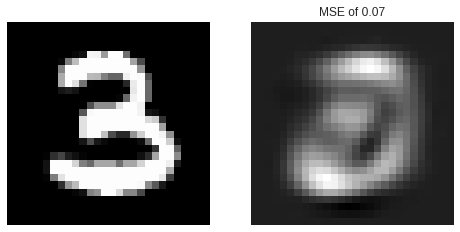

1

In [0]:
def plot_recons_original(image, label):
  ## Function used to plot image x and reconstructed image \psi\phi(x)
  # Reshape (just in case) and predict using model
  if len(image.shape) == 1:
    image = image.reshape(1, -1)
  reconst_image = model.predict(image)
  # Evaluate MSE to also report it in the image
  mse = model.evaluate(image, image, verbose=0)
  # Create a figure with 1 row and 2 columns
  plt.subplots(1,2)
  # Select first image in the figure
  ax = plt.subplot(121)
  # Plot image x
  plt.imshow(image.reshape(28,28), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Select second image in the figure
  ax = plt.subplot(122)
  # Plot reconstructed image
  plt.imshow(reconst_image.reshape(28,28), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Set a title to the current axis (second figure)
  plt.title('MSE of {:.2f}'.format(mse[0]))
  plt.show()

# Select a random index from the test set
ind = np.random.randint(x_test.shape[0] -  1)
plot_recons_original(x_test[ind], y_test[ind])

We see how the reconstructed images look in most cases blurry, due to the autoencoder $\psi(\phi(x))$ not having enough representation capacity. We will try to improve the model later by adding some non-linearities/more layers, but first let's check how the feature vectors are distributed in the representation space.

## Representation space
If we have a good representation, we hope to see in the representation space clusters of similar points in the image space. For example, images from the same class should be close to each other.

To check how the features are distributed in the representation space, we forward the images from the test set to the autoencoder and retrieve the representation $\phi(x)$ in the layer with `name='representation'`. As the vector only has dimensionality 2 (we used `Dense(2...)`), we do not need to apply any dimensionality reduction technique such as PCA to plot it.

We first compute the representation of the images from the MNIST test set using the `predict_representation` function. The function uses the name we gave to the layer to retrieve the representation vector, it forms a new model that instead of doing $\psi(\phi(x))$ it only computes $\phi(x)$.

In [0]:
def predict_representation(model, data, layer_name='representation'):
  ## We form a new model. Instead of doing \psi\phi(x), we only take \phi(x)
  ## To do so, we use the layer name
  intermediate_layer_model = Model(inputs=model.input,
                                   outputs=model.get_layer(layer_name).output)
  representation = intermediate_layer_model.predict(data)
  representation = representation.reshape(representation.shape[0], -1)
  return representation

representation = predict_representation(model, x_test)

Now, we plot the computed representation for the test images in a 2D scatter plot. We also use in the scatter plot the corresponding label by assigning different colours to the labels.

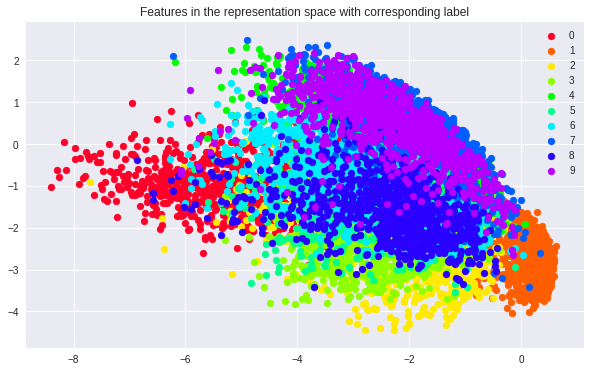

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4c97b8c790>)

In [0]:
def plot_representation_label(representation, labels, plot3d=0):
  ## Function used to plot the representation vectors and assign different 
  ## colors to the different classes

  # First create the figure
  fig, ax = plt.subplots(figsize=(10,6))
  # In case representation dimension is 3, we can plot in a 3d projection too
  if plot3d:
    ax = fig.add_subplot(111, projection='3d')
    
  # Check number of labels to separate by colors
  n_labels = labels.max() + 1
  # Color map, and give different colors to every label
  cm = plt.get_cmap('gist_rainbow')
  ax.set_prop_cycle(color=[cm(1.*i/(n_labels)) for i in range(n_labels)])
  # Loop is to plot different color for each label
  for l in range(n_labels):
    # Only select indices for corresponding label
    ind = labels == l
    if plot3d:
      ax.scatter(representation[ind, 0], representation[ind, 1], 
                 representation[ind, 2], label=str(l))
    else:
      ax.scatter(representation[ind, 0], representation[ind, 1], label=str(l))
  ax.legend()
  plt.title('Features in the representation space with corresponding label')
  plt.show()
  return fig, ax

plot_representation_label(representation, y_test)

The representation of the images from the same class are close to each other (each colour is a different digit). However, some of the classes seem to overlap with each other, and there are some classes that are more clustered than others. For example, the class `1`is well clustered, but the class `9` seems to overlap greatly with the class `7`.  The class `8` is also quite spread out, with some of the features closer to the features of the class `1`, some others closer to the class `0` and so on.

## Clustering the data
We have learnt a representation, and we also plotted it in the last section. We saw how the representation for the different images from the same label were close to each other without actually using the label information in the training process. Now, let's do a quick experiment to see how well clustered are the features. We will use a clustering method on these features, and then assign each of the clusters to the majority class (most represented class in the cluster). We want to check what kind of accuracy we would have using this simple classification method as a way to understand how well clustered they are.

First, let's now cluster the features using a standard technique called K-Means. A good guess is to use the same number of clusters as classes, in this case 10. Then, as we mentioned, assign each of the clusters to the majority class. And then we 

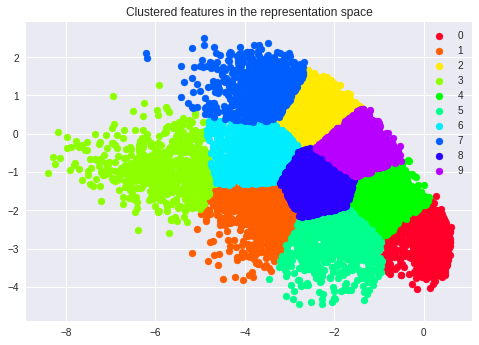

Accuracy of 0.397


In [0]:
def cluster_plot_data(representation):
  from sklearn.cluster import KMeans
  # Set number of clusters to 10
  n_clusters = 10
  # Use KMeans
  c_pred = KMeans(n_clusters=n_clusters).fit_predict(representation)
  _, ax = plt.subplots(1,1)
  # Color map, and give different colors to every label
  cm = plt.get_cmap('gist_rainbow')
  ax.set_prop_cycle(color=[cm(1.*i/(n_clusters)) for i in range(n_clusters)])
  # Loop is to plot different color for each label
  for c in range(n_clusters):
    # Only select indices for corresponding label
    ind = c_pred == c
    ax.scatter(representation[ind, 0], representation[ind, 1], label=str(c))
  ax.legend()
  plt.title('Clustered features in the representation space')
  plt.show()
  return c_pred

c_pred = cluster_plot_data(representation)

# Compute accuracy by checking cluster by cluster the majority class and
# assigning all of the data points in that cluster to the majority class
# Then we check the accuracy of doing so
correct = 0
for i in range(10):
  indices_c_pred = c_pred == i
  classes = y_test[indices_c_pred]
  counts = np.bincount(classes)
  class_max = np.argmax(counts)
  correct += (classes == class_max).sum()
  
print('Accuracy of {:.3f}'.format(correct/(1.0*y_test.shape[0])))

Even though it is not a good way to classify the samples as it is quite simple, the accuracy is still quite higher than random guess, which would be around ~10%.

## Relationship to PCA

In the lecture session, it was mentioned that a linear autoencoder has a relationship with PCA, i.e. using an autoencoder with representation dimensionality of $d$ was equivalent to finding the first $d$ principal components. Let's test it by computing the PCA of the train set, and applying it in the test set. Then we will check the representation space plot, and the reconstruction MSE and check if they are consistent with what we obtained with the autoencoder.

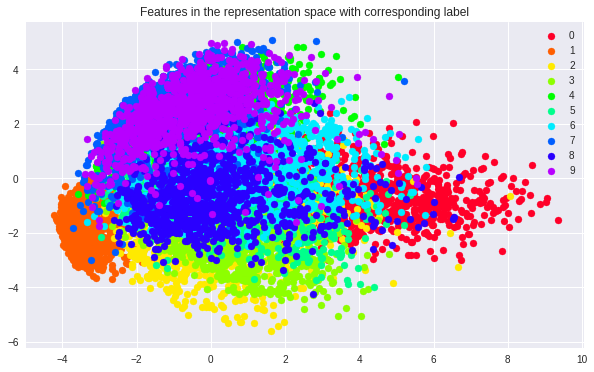

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(x_train)
representation_pca = pca.transform(x_test)
plot_representation_label(representation_pca, y_test)
plt.show()

The resulting figure for PCA is similar to the one obtained in the linear autoencoder section, being the main difference that this one is mirrored. 

We now check if the given MSE in the test set is similar to the linear autoencoder we trained before.

In [0]:
reconst_test = pca.inverse_transform(representation_pca)
mse_pca = ((reconst_test - x_test)**2).mean()

print('Test MSE for PCA is {:.4f}'.format(mse_pca))

Test MSE for PCA is 0.0557


The reconstruction error we get is almost the same as the one obtained with the autoencoder case, with only a small variation, the variation due to the stochastic training in the autoencoder case. This validates the claim that a linear autoencoder acts as PCA.

## Non-linear transformations

We want to give to $\phi$ more representation capacity, to do so we add non-linearities in the model. We designed a quite simple non-linear model by adding some non-linearities to it which has a lower MSE error than the linear model. However, it is quite easy to give it more capacity by adding more layers. 

**Exercise:** Experiment a little bit with the model and non-linearities. Try to reduce the MSE to less than 0.045 in the test set. Also, you can check the variation in representation capacity when changing the number of dimensions in the `representation` layer, as 2 is a big constraint. Plot the reconstructed images for your model and check if they have improved compared to the linear case. Also, plot the features in the representation space to see how the features are distributed.

In [0]:
### Modify the model here
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(2, name='representation'))
model.add(Dense(784, activation='sigmoid'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
print(model.summary())
epochs = 10
validation_split = 0.1
history = model.fit(x_train, x_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
representation (Dense)       (None, 2)                 258       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               2352      
Total params: 103,090
Trainable params: 103,090
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 4s 66us/step - loss: 0.0799 - mean_squared_error: 0.0799 - val_loss: 0.0624 - val_mean_squared_error: 0.0624
Epoch 2/10
54000/54000 [==============================] - 3s 51us/step - loss: 0.0605 - mean_squared_error: 0.0605 - val_loss: 0.0587 - val_mean_squared_error: 0.0587
Epoch 3/10
5

As before, we evaluate the MSE obtained in the test set.

In [0]:
print('Test MSE obtained is {:.4f}'.format(model.evaluate(x_test, x_test)[0]))

10000/10000 [==============================] - 1s 75us/step
Test MSE obtained is 0.0544


And now we check how the reconstructed images look. If you improved the model, they should be better compared to the linear model.

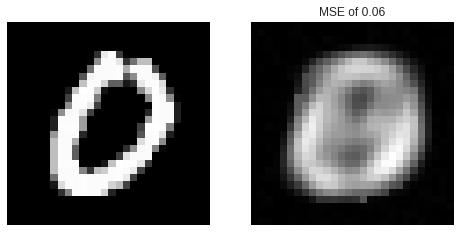

1

In [0]:
ind = np.random.randint(x_test.shape[0] -  1)
plot_recons_original(x_test[ind], y_test[ind])

Now we plot the new features we obtained with the designed non-linear model. You can use a representation layer with dimensionality 3 and plot it by passing the argument `plot3d=1` to `plot_representation_label`.

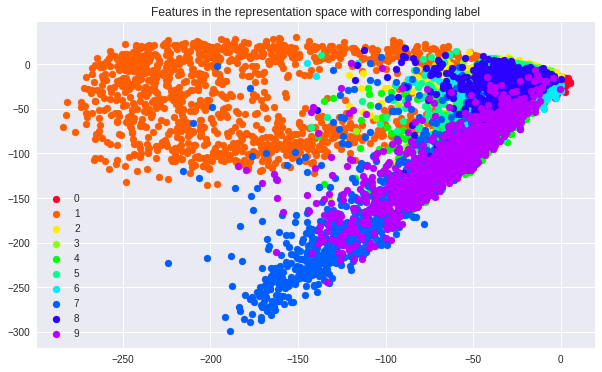

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4c978d29d0>)

In [0]:
representation = predict_representation(model, x_test)

## EXTRA: If your autoencoder contains a representation layer 
## with more than 2/3 dimensions, you can project the representations to a lower
## dimensionality space first by using dimensionality reduction techniques such 
## as PCA or TSNE. TSNE is slower, but results in quite nice visualizations,
## where the different classes form quite distinctive clusters
## TSNE: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

## PCA code
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca = pca.fit(predict_representation(model, x_train))
# representation_pca = pca.transform(representation)

## TSNE code (~80 seconds)
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# representation_tsne = tsne.fit_transform(representation)

plot_representation_label(representation, y_test, plot3d=0)

## Detecting anomalies

After checking the representation of the MNIST images, let's focus on how to spot anomalies in the data, which are samples that deviate from the usual distribution. In the slides (Applications:  Anomaly Detection) it is mentioned how when given a data point from another distribution, the reconstruction error will be higher. We now will test that. To do so, we will use the Extended MNIST (EMNIST) dataset, which apart from digits, includes also both lowercase and uppercase characters from a to z.

Let's start by downloading and loading the dataset. The following piece of code downloads the data and uncompresses some necessary files.

In [0]:
!wget http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip -q
!unzip -qq ./gzip.zip
!mv gzip data
# We need to unzip a couple of files with the train
# labels and images 
!gunzip ./data/emnist-byclass-test-images-idx3-ubyte.gz 
!gunzip ./data/emnist-byclass-test-labels-idx1-ubyte.gz
# We also install a package to help us 
!pip install python-mnist

Now that we have downloaded the data, we will use the module `mnist` to load the images in the same format as the regular MNIST dataset included in Keras.

In [0]:
from mnist import MNIST

# Images in folder data
mndata = MNIST('data')

# This will load the test data from the downloaded files
emnist_x_test, emnist_y_test = mndata.load('./data/emnist-byclass-test-images-idx3-ubyte',
                               './data/emnist-byclass-test-labels-idx1-ubyte')


# Convert data to numpy arrays and normalize images to the interval [0, 1]
n_elem = len(emnist_x_test)
emnist_x_test = np.array(emnist_x_test).reshape(n_elem,28,28).transpose(0,2,1).reshape(n_elem,28**2) / 255.0
emnist_y_test = np.array(emnist_y_test)

# Get labels mapping (index in emnist_y_test to character value)
emnist_labels = map(lambda x: x.strip('\r').split(' '), open('./data/emnist-byclass-mapping.txt').read().strip().split('\n'))
emnist_labels = dict(emnist_labels)

# This function will be useful to display the actual label, which is given as
# an ascii value (https://en.wikipedia.org/wiki/ASCII) instead of characters
def label_to_char(label):
  ascii_val = emnist_labels[str(label)]
  return chr(int(ascii_val))

Here we just plot a random image from the EMNIST dataset. Each time you run it, you get a random image from the dataset, in case you want to check how the different characters look.

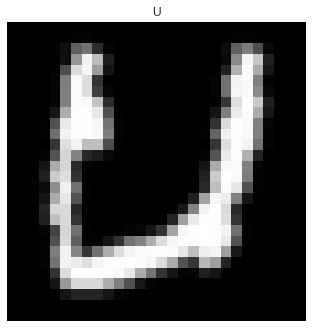

In [0]:
ind_plot = np.random.randint(emnist_x_test.shape[0]-1)
_, ax = plt.subplots(1,1)
plt.imshow(emnist_x_test[ind_plot].reshape(28, 28), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
# We use the label_to_char function to plot the actual character in the
# figure title
plt.title(label_to_char(emnist_y_test[ind_plot]))
plt.show()

Now we have loaded the EMNIST dataset. The images contain characters that the autoencoder has not seen before, hence the reconstruction error (we use Mean Squared Error as the reconstruction metric) for the EMNIST dataset should be higher. We will first compute the reconstruction error for the MNIST test data, and then compute the same for the EMNIST data. Then, we compare the distribution of reconstruction error in both sets using a histogram visualization.

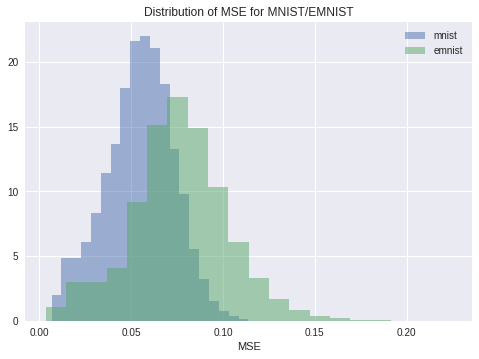

In [0]:
def compute_errors(model, mnist_data, emnist_data):
  ## This function plots the histogram of mse for a given model and two 
  ## datasets (assuming mnist and emnist in this case)
  ## The function also returns the mse per sample for both datasets and the
  ## recontructed images for both datasets
  
  # Predict reconstructed images for mnist
  reconst_mnist = model.predict(mnist_data)
  # Reshape and compute mse per image
  reconst_mnist = reconst_mnist.reshape(reconst_mnist.shape[0], -1)
  mnist_data = mnist_data.reshape(mnist_data.shape[0], -1)
  mse_mnist = ((reconst_mnist - mnist_data)**2).mean(-1)
  # Plot histogram, with density=True we normalize so the area adds up to 1
  plt.hist(mse_mnist, bins=20, label='mnist', alpha=0.5, density=True)
  
  # Same for EMNIST, first predict reconstructed images
  reconst_emnist = model.predict(emnist_data)
  # Reshape and compute mse per image
  reconst_emnist = reconst_emnist.reshape(reconst_emnist.shape[0], -1)
  emnist_data = emnist_data.reshape(emnist_data.shape[0], -1)
  mse_emnist = ((reconst_emnist - emnist_data)**2).mean(-1)
  # Plot histogram
  plt.hist(mse_emnist, bins=20, label='emnist', alpha=0.5, density=True)
  # Title, label and legend
  plt.xlabel('MSE')
  plt.title('Distribution of MSE for MNIST/EMNIST')
  plt.legend()
  plt.show()
  return reconst_mnist, mse_mnist, reconst_emnist, mse_emnist

reconst_mnist, mse_mnist, reconst_emnist, mse_emnist = compute_errors(model, 
                                                                      x_test, 
                                                                      emnist_x_test)

As we expected, the distribution of errors for the EMNIST dataset has a higher mean and variance compared to the original MNIST. Let's now check how the image with the least reconstruction error and the image with the most reconstruction error look.

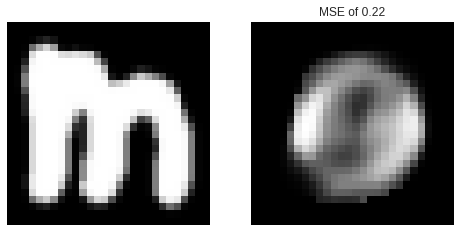

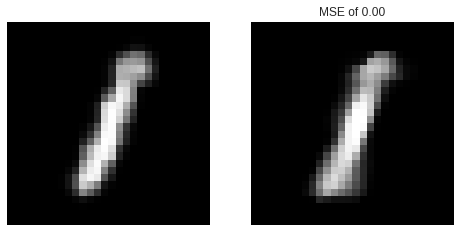

1

In [0]:
plot_recons_original(emnist_x_test[mse_emnist.argmax()], emnist_y_test[mse_emnist.argmax()])
plot_recons_original(emnist_x_test[mse_emnist.argmin()], emnist_y_test[mse_emnist.argmin()])

It looks like the model is not capable of representing images from EMNIST that differ in a great way to the MNIST images. However, it behaves well for images that are similar to those from MNIST, which is what we expected.

We now perform an anomaly detection exercise. We set the threshold $\tau$, which we use to mark a data point as an anomaly if $||x-\psi(\phi(x))||^2>\tau$, as $\tau = \mu + 2\sigma$, where $\mu$ is the average MSE for the whole MNIST test set, and $\sigma$ is the standard deviation of the MSE in the MNIST test set. We will now plot the ratio of data points marked as anomalies for each of the classes in both MNIST and EMNIST. Additionally, we also report the average MSE per class in both datasets. We expect to see that the MNIST anomalies are quite lower compared to the EMNIST dataset, as the model has been trained with MNIST data.

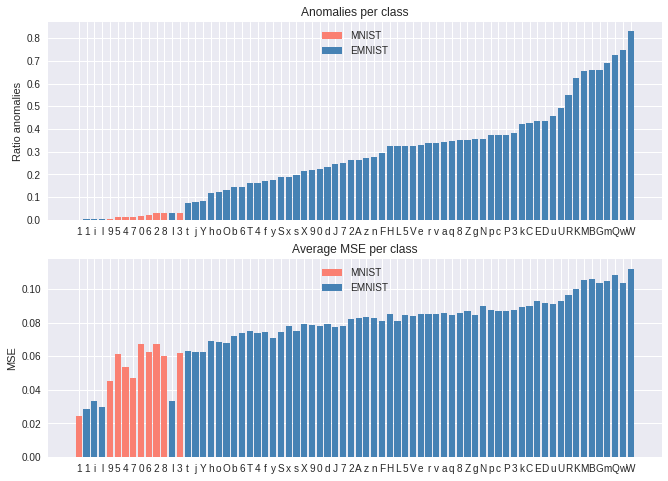

In [0]:
def print_mse_anomalies(mse_mnist, mse_emnist, emnist_labels, th=-1):
  ## This function uses the mse per class in both MNIST and EMNIST
  ## to compute the ratio of anomalies per class (anomalies/examples per class)
  ## We plot anomalies and mse in a bar histogram, ordered by ratio of anomalies
  ## Do not worry too much about how it works.
  
  # If no threshold (\tau) is given, we set it to \mu + 2\sigma
  if th == -1:
    th = 2*mse_mnist.std() + mse_mnist.mean()
  # MNIST labels are from 0-9
  mnist_labels = range(10)  
  
  # Initialize a list where we will save the 
  save_array = []
  
  # We start with MNIST
  for label in mnist_labels:
    # Indices with class == label
    indices_class = y_test == int(label)
    # Ratio of anomalies
    ratio_anom = (mse_mnist[indices_class] > th).sum()/(1.0*indices_class.sum())
    # Form an array with the mean mse in the class, the ratio of anomalies,
    # the corresponding label and a color which will use to plot this
    save_array.append([mse_mnist[indices_class].mean(), 
                       ratio_anom, str(label), 'salmon'])
  # Next is EMNIST
  for label in emnist_labels:
    indices_class = emnist_y_test == int(label)
    ratio_anom = (mse_emnist[indices_class] > th).sum()/(1.0*indices_class.sum())
    save_array.append([mse_emnist[indices_class].mean(), 
                       ratio_anom, label_to_char(label), 'steelblue'])
  
  # Number of total classes
  n_classes = len(save_array)    
  # We have a list of lists in distance_classes, we want to sort it by the 
  # ratio of anomalies, which is the index 1. To do so, we use sorted with
  # key=lambda x: x[1]
  save_array = sorted(save_array, key=lambda x: x[1])
  
  # Retrieve mse, anomalies, labels names and colors to plot from save_array
  mse_class = map(lambda x: x[0], save_array)
  anomalies_class = map(lambda x: x[1], save_array)
  labels_names = map(lambda x: x[2], save_array)
  colors = map(lambda x: x[3], save_array)
  
  # Plotting stuff
  plt.subplots(2,1, figsize=(11,8))
  plt.subplot(2,1,1)
  bars = plt.bar(range(n_classes), anomalies_class, color=colors)
  plt.xticks(range(n_classes), labels_names)
  plt.legend([bars[0],bars[-1]], ['MNIST', 'EMNIST'], loc='upper center')
  plt.title('Anomalies per class')
  plt.ylabel('Ratio anomalies')
  plt.subplot(2,1,2)
  plt.bar(range(n_classes), mse_class, color=colors)
  plt.xticks(range(n_classes), labels_names)
  plt.legend([bars[0],bars[-1]], ['MNIST', 'EMNIST'], loc='upper center')
  plt.title('Average MSE per class')
  plt.ylabel('MSE')
  plt.show()
print_mse_anomalies(mse_mnist, mse_emnist, emnist_labels)

The top figure shows the ratio of anomalies per class, which is the number of anomalies detected for the data points of that class divided by the number of examples of that specific class. The bottom figure shows the mean error per category, where we can see that the classes from EMNIST have a higher reconstruction error than those from MNIST. Even the same classes, the digits 0-9, have a different distribution as we can see how the error in EMNIST is higher for the same class. Additionally, some easy letters that look like the number 1 (`l, I, i, t, j`) or like 0 (`O` and `o`) have a low reconstruction error as they are similar to some classes in the MNIST dataset. Some other classes, such as `W`, `w`, or `Q` have a high reconstruction error due to being quite dissimilar to any of the images in MNIST.

We have seen that data from other datasets will have a high MSE. However, even for MNIST, we can look for samples that have a high reconstruction error compared to the mean. In the same class, there will be differences, which are called intra-class differences. We expect to see that several images will follow a similar distribution, however some of them will deviate from this distribution 

Now, let's take one of the classes from MNIST and plot some images with high reconstruction error and some others with low reconstruction error. We expect to see those with low reconstruction error to be quite similar between them and represent what the average sample of that class looks like. The high reconstruction error samples will, in turn, contain some elements (pose, shape for example).


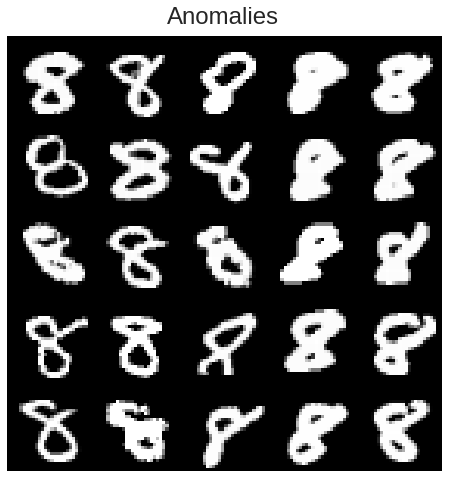

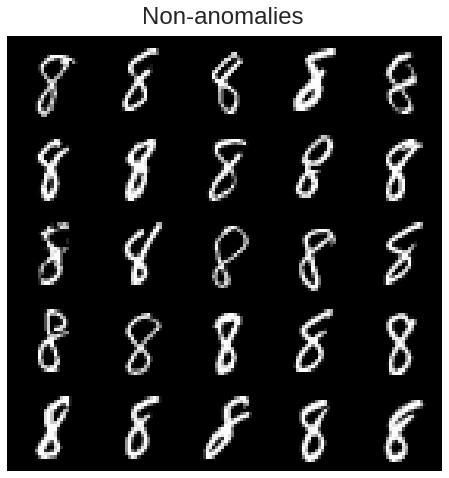

In [0]:
# Set same threshold we defined before \mu + 2\sigma
th = 2*mse_mnist.std() + mse_mnist.mean()

# We will use the label 8 for the example
indices_class = y_test == 8

# Compute the number of anomalies (mse > th)
anomalies_im = x_test[indices_class][mse_mnist[indices_class] > th]

# For the nonanomalies, we will sort the images by reconstruction error
# So we will plot the images with low reconstruction error
indices_sort = np.argsort(mse_mnist[indices_class])
nonanomalies_im = x_test[indices_class][indices_sort]

def plot_grid(images, N=5, title=''):
  ## Plots data in variable images in a grid of N*N
  # Create figure
  fig, axes = plt.subplots(N,N, figsize=(8,8))
  # Loop to generate grid
  for row in range(N):
    for col in range(N):
      idx = row+N*col
      axes[row,col].imshow(images[idx].reshape(28,28), cmap='gray')
      axes[row,col].set_xticks([])
      axes[row,col].set_yticks([])
  
  # Adjust white space
  fig.subplots_adjust(hspace=0.0)
  fig.subplots_adjust(wspace=0.0)
  fig.subplots_adjust(right=1.0)
  fig.subplots_adjust(left=0.245)
  # Set title
  fig.suptitle(title, x=0.62, y=0.93, fontsize=24)

# Plot anomalies
plot_grid(anomalies_im, title='Anomalies')
# Plot non-anomalies
plot_grid(nonanomalies_im, title='Non-anomalies')

The images that are anomalies (for the given threshold $\tau$) show a much larger variation in shape and pose. In turn, the images with low reconstruction error for the selected label (in this case `8`) show similar proportions and less variation between any two images.